In [1]:
from google.colab import drive  # Mount Google Drive in Colab.
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install librosa --upgrade  # Upgrade librosa to the latest version.

In [4]:
import pandas as pd  # Import pandas for data manipulation and analysis.
import numpy as np  # Import NumPy for numerical computations.

import os  # Import os for interacting with the operating system.
import sys  # Import sys for system-specific parameters and functions.

# librosa is a library for audio and music analysis.
import librosa  
import librosa.display  # Import librosa display utilities for visualizing audio data.

import seaborn as sns  # Import seaborn for data visualization.
import matplotlib.pyplot as plt  # Import Matplotlib for plotting graphs.

from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Import tools for feature scaling and encoding.
from sklearn.metrics import confusion_matrix, classification_report  # Import tools for evaluating model performance.
from sklearn.model_selection import train_test_split  # Import function for splitting data into training and testing sets.

# Libraries for playing audio files in Jupyter notebooks.
import IPython.display as ipd 
from IPython.display import Audio  

import warnings  # Import warnings to manage warning messages.
if not sys.warnoptions:
    warnings.simplefilter("ignore")  # Ignore all warning messages.
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Ignore deprecation warnings specifically.

## Import Dataset and Understanding

In [6]:
# Set the path and list directories to locate dataset files.
path = '/content/drive/MyDrive/BANGKIT SMT 5/CAPSTONE/dataset/audio_speech_actors_01-24/'
ravdess_directory_list = os.listdir(path)

# Extract emotion labels and file paths from the dataset.
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(path + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(path + dir + '/' + file)

# Create a DataFrame combining emotion labels and file paths.
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Map numeric emotion labels to descriptive emotion names.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

<ipython-input-6-42f2673cb716>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)


,Emotions,Path
0,neutral,/content/drive/MyDrive/BANGKIT SMT 5/CAPSTONE/...
1,calm,/content/drive/MyDrive/BANGKIT SMT 5/CAPSTONE/...
2,neutral,/content/drive/MyDrive/BANGKIT SMT 5/CAPSTONE/...
3,calm,/content/drive/MyDrive/BANGKIT SMT 5/CAPSTONE/...
4,neutral,/content/drive/MyDrive/BANGKIT SMT 5/CAPSTONE/...


In [7]:
# Print the count of each emotion category.
print(Ravdess_df.Emotions.value_counts())

Emotions
calm        192
happy       192
sad         192
fear        192
angry       192
disgust     192
surprise    192
neutral      96
Name: count, dtype: int64


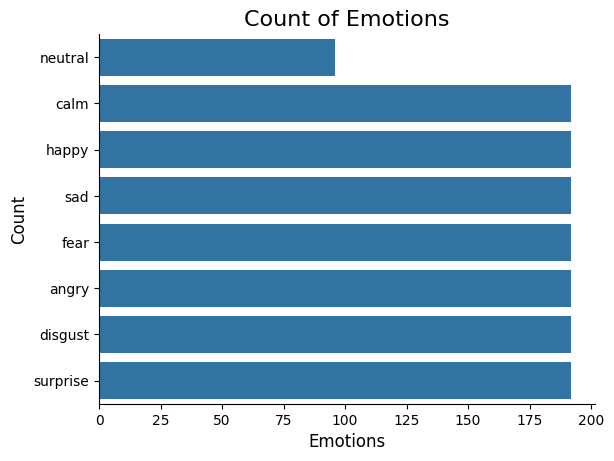

In [8]:
# Plotting the count of emotions from the Ravdess dataset
plt.title('Count of Emotions', size=16)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [9]:
# Funtion to displaying the waveplot for the given emotion
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
# Function to displaying spectrogram for the given emotion
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

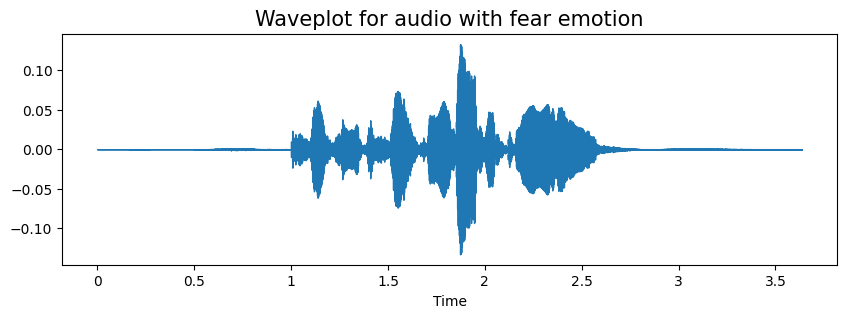

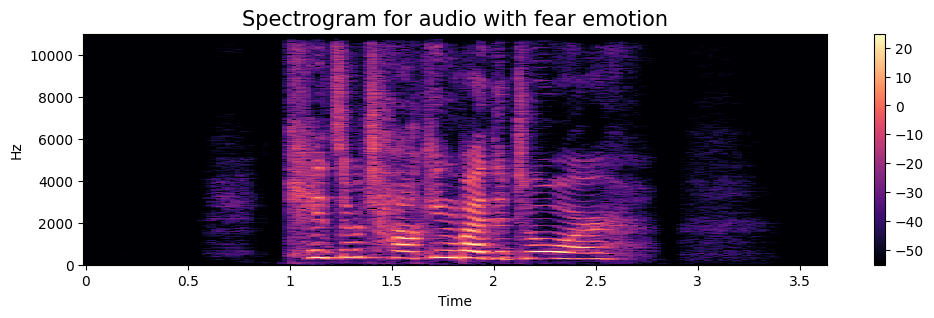

In [10]:
# Load and visualize the audio data for the 'fear' emotion with a waveplot, spectrogram, and playback
emotion='fear'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

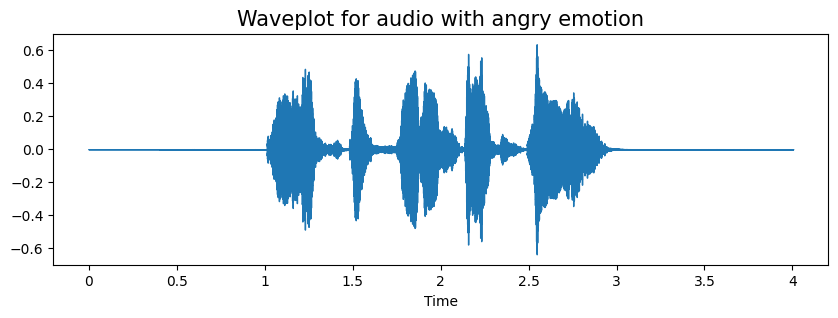

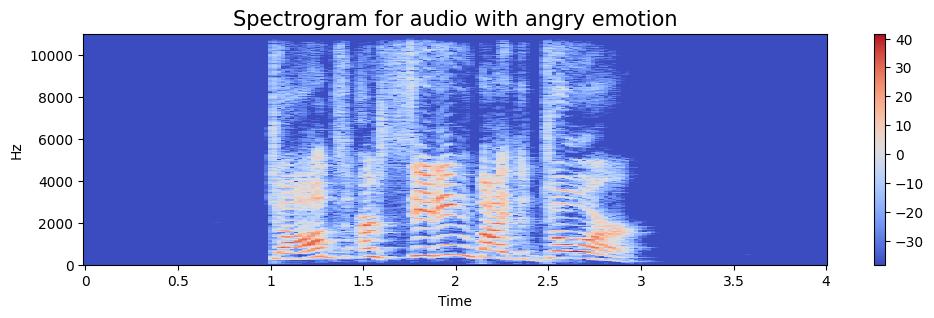

In [11]:
# Load and visualize the audio data for the 'angry' emotion with a waveplot, spectrogram, and playback
emotion='angry'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Augmentation Data

The data per label is small, so data augmentation will be applied.

In [12]:
# Functions for audio augmentation: noise addition, time stretching, shifting, and pitch shifting
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

## FEATURE EXTRACTION


In [13]:
# Zero Crossing Rate (ZCR) calculation: Computes the rate of sign changes in the audio signal
def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

# Root Mean Square Error (RMSE) calculation: Computes the energy in the audio signal
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

# Mel-Frequency Cepstral Coefficients (MFCC) extraction: Computes MFCC features for audio signal
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc_result = librosa.feature.mfcc(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(mfcc_result.T) if not flatten else np.ravel(mfcc_result.T)

# Feature extraction: Combines ZCR, RMSE, and MFCC extraction into a single feature set
def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])

    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                        ))

    return result

# Audio feature extraction with augmentation: Extracts features from original and augmented (noised, pitched) audio
def get_features(path, duration=2.5, offset=0.6):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    aud = extract_features(data)
    audio = np.array(aud)

    # Add noise to audio and extract features
    noised_audio = noise(data)
    aud2 = extract_features(noised_audio)
    audio = np.vstack((audio, aud2))

    # Pitch shift audio and extract features
    pitched_audio = pitch(data, sr)
    aud3 = extract_features(pitched_audio)
    audio = np.vstack((audio, aud3))

    # Add noise to pitch-shifted audio and extract features
    pitched_audio1 = pitch(data, sr)
    pitched_noised_audio = noise(pitched_audio1)
    aud4 = extract_features(pitched_noised_audio)
    audio = np.vstack((audio, aud4))

    return audio


In [15]:
# Measure the time taken to extract features from audio files and store them along with their corresponding emotions
import timeit
from tqdm import tqdm

start = timeit.default_timer()  # Start timer
X, Y = [], []  # Initialize lists to store features and labels
for path, emotion, index in tqdm(zip(Ravdess_df.Path, Ravdess_df.Emotions, range(Ravdess_df.Path.shape[0]))):
    features = get_features(path)  # Extract features for each audio file
    if index % 500 == 0:  # Print progress for every 500th file processed
        print(f'{index} audio has been processed')
    for i in features:  # Append extracted features and corresponding emotion
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()  # Stop timer

print('Time: ', stop - start)  # Print the total time taken

1it [00:03,  3.07s/it]

0 audio has been processed


501it [05:49,  1.41it/s]

500 audio has been processed


1001it [11:12,  1.54it/s]

1000 audio has been processed


1440it [16:09,  1.48it/s]

Done
Time:  969.753692219


In [17]:
# Check the lengths of feature set X, label set Y, and the number of audio files in the dataset
len(X), len(Y), Ravdess_df.Path.shape


(5760, 5760, (1440,))

In [18]:
# Create a DataFrame from the feature set X and label set Y, then save it as a CSV file
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.358887,0.483398,0.644531,0.678711,0.713867,0.771973,0.839844,0.825684,0.812500,0.855469,...,2.533295,2.229258,1.982186,1.749773,1.501692,1.217998,0.886900,0.503848,0.072850,neutral
1,0.245117,0.365723,0.480469,0.487793,0.498047,0.508301,0.521973,0.511719,0.502930,0.498535,...,0.858095,-2.919686,-5.118379,-1.826502,5.899706,6.857175,6.837238,2.397680,0.441354,neutral
2,0.232910,0.356934,0.494141,0.518555,0.542480,0.530273,0.513184,0.488770,0.475586,0.525391,...,1.990278,1.506036,1.126577,0.847949,0.660856,0.552712,0.509699,0.518360,0.567152,neutral
3,0.245605,0.368652,0.487793,0.476562,0.497559,0.507324,0.513672,0.524902,0.513672,0.503418,...,-0.209805,1.588095,2.834593,-3.027594,0.381500,3.509603,5.195369,5.195878,1.248312,neutral
4,0.096191,0.201172,0.201172,0.201172,0.181641,0.077148,0.077148,0.077148,0.000000,0.000000,...,1.396904,1.719505,0.914893,-0.177435,-0.442087,0.289536,1.009058,0.567127,-1.058780,calm


## Build the Model

In [19]:
# Import necessary libraries for deep learning with Keras
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [21]:
# Check for missing values (NaNs) in the 'Emotions' DataFrame
np.sum(Emotions.isna())

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,0
0,0
1,0
2,0
3,0
4,0
...,...
2372,60
2373,60
2374,60
2375,60


In [22]:
# Fill missing values in the 'Emotions' DataFrame with 0 and check for any remaining missing values
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(5760, 2377)

In [23]:
# Split the 'Emotions' DataFrame into feature set X (all columns except the last) and label set Y (last column)
X = Emotions.iloc[:, :-1].values  # Take all rows and all columns except the last for features
Y = Emotions['Emotions'].values  # Take the last column as the labels (emotions)


In [24]:
# As this is a multiclass classification problem onehotencoding our Y
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [25]:
# Print the shapes of the label set Y and feature set X
print(Y.shape)
X.shape

(5760, 8)


(5760, 2376)

In [26]:
# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4608, 2376), (4608, 8), (1152, 2376), (1152, 8))

In [27]:
# Reshape the training and testing feature sets to have a third dimension (for compatibility with CNN models)
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [28]:
# Scale the training and testing data using StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4608, 2376), (4608, 8), (1152, 2376), (1152, 8))

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau

# Define a callback to save the best model weights based on validation accuracy
model_checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

In [30]:
# Define early stopping callback to stop training when validation accuracy stops improving
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, restore_best_weights=True)

# Define learning rate reduction callback to reduce the learning rate if the validation accuracy plateaus
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [31]:
# Expand the dimensions of the training and testing feature sets to match the input shape for CNN models

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((4608, 2376, 1), (4608, 8), (1152, 2376, 1), (1152, 8))

In [38]:
# Tensorflow for model
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import Dropout

# Define the CNN model
model = tf.keras.Sequential([
    # First Convolutional Layer and MaxPooling
    L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding='same'),

    # Second Convolutional Layer and MaxPooling
    L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding='same'),
    Dropout(0.3),  # Add dropout for regularization

    # Third Convolutional Layer and MaxPooling
    L.Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=2, strides=2, padding='same'),

    # Flatten and Fully Connected Layers
    L.Flatten(),
    L.Dense(128, activation='relu'),
    Dropout(0.3),  # Additional dropout in fully connected layer
    L.BatchNormalization(),
    L.Dense(8, activation='softmax')  # Output layer with 8 classes (emotion categories)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 2376, 256)           │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 2376, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 1188, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 1188, 128)           │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 1188, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 594, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 594, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 594, 64)             │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 594, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 297, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 19008)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       2,433,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,560,584 (9.77 MB)

 Trainable params: 2,559,432 (9.76 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [39]:
# Train the CNN model with early stopping, learning rate reduction, and model checkpointing
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 279s 4s/step - accuracy: 0.3662 - loss: 1.8741 - val_accuracy: 0.0634 - val_loss: 9.8001 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 269s 4s/step - accuracy: 0.6833 - loss: 0.9575 - val_accuracy: 0.0634 - val_loss: 10.6155 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - accuracy: 0.8452 - loss: 0.5121 - val_accuracy: 0.2101 - val_loss: 4.8691 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 279s 4s/step - accuracy: 0.9359 - loss: 0.2905 - val_accuracy: 0.3255 - val_loss: 3.8199 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 313s 4s/step - accuracy: 0.9727 - loss: 0.1647 - val_accuracy: 0.4583 - val_loss: 2.4512 - learning_rate: 0.0010
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 330s 4s/step - accuracy: 0.9838 - loss: 0.1014 - val_accuracy: 0.6632 - val_loss: 1.0334 - learning_rate: 0.0010
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - accuracy: 0.9872 - loss: 0.0808 - val_ac

36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - accuracy: 0.9466 - loss: 0.2192
Accuracy of our model on test data :  93.75 %


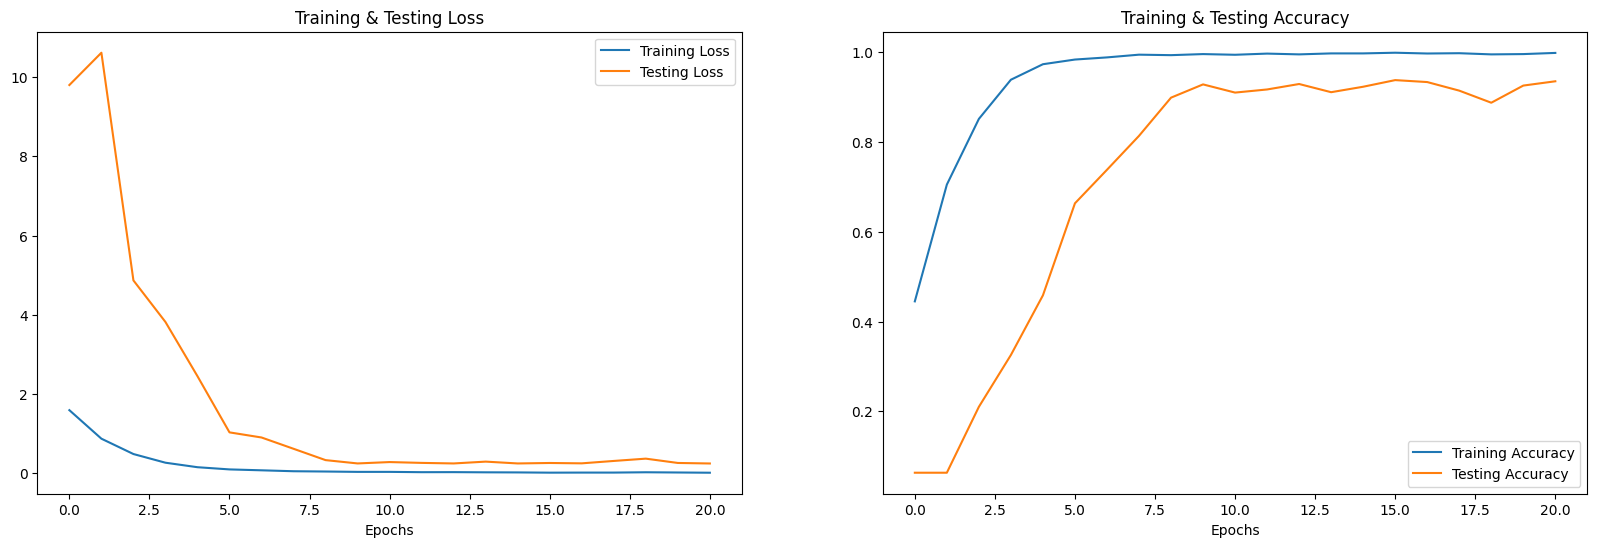

In [41]:
# Evaluate the model on test data and plot training/testing loss and accuracy curves
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

num_epochs = len(history.history['loss'])
epochs = [i for i in range(num_epochs)]

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [42]:
# Predict on test data
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 438ms/step


,Predicted Labels,Actual Labels
0,angry,angry
1,sad,sad
2,calm,calm
3,angry,angry
4,calm,calm
5,sad,sad
6,happy,happy
7,calm,calm
8,happy,happy
9,disgust,disgust


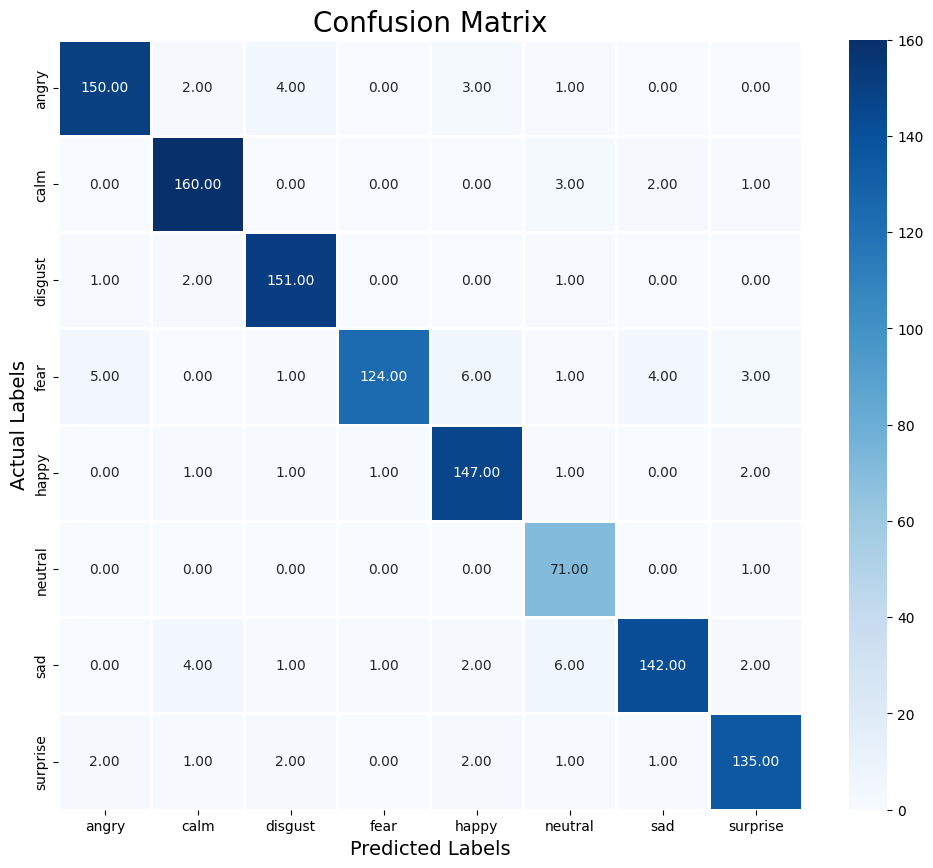

              precision    recall  f1-score   support

       angry       0.95      0.94      0.94       160
        calm       0.94      0.96      0.95       166
     disgust       0.94      0.97      0.96       155
        fear       0.98      0.86      0.92       144
       happy       0.92      0.96      0.94       153
     neutral       0.84      0.99      0.90        72
         sad       0.95      0.90      0.93       158
    surprise       0.94      0.94      0.94       144

    accuracy                           0.94      1152
   macro avg       0.93      0.94      0.93      1152
weighted avg       0.94      0.94      0.94      1152



In [43]:
# Generate and visualize the confusion matrix, followed by displaying the classification report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

## Save Model

In [44]:
# Serialize the model architecture to JSON and save the weights to an HDF5 file
from tensorflow.keras.models import Sequential, model_from_json

# JSON
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# HDF5
model.save_weights("CNN_model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [45]:
import pickle

# Saving scaler
with open('scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder.pickle', 'rb') as f:
    encoder2 = pickle.load(f)